# Borrower reliability analysis

The client is the credit department of the bank. We need to understand whether the marital status and number of children of the client affects the fact of repayment of the loan on time. Input data from the bank - statistics on the solvency of customers.

The study results will be taken into account when building a **credit scoring model** - a special system that evaluates the potential borrower's ability to repay the loan to the bank.

## Step 1: Getting familiar with the data and exploring general information

In [1]:
# Import libriaries
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from pymystem3 import Mystem

In [2]:
# Read the table with the data and save it in the variable df
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Explore general information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
# Check if the same rows have missing values in days_employed and total_income columns
df[df['days_employed'].isna()].all() == df[df['total_income'].isna()].all()

children            True
days_employed       True
dob_years           True
education           True
education_id        True
family_status       True
family_status_id    True
gender              True
income_type         True
debt                True
total_income        True
purpose             True
dtype: bool

In [5]:
# Number of missing values

len(df[df['days_employed'].isna()])

2174

**Summary**  
Yes, both values are missing at the same time in the same row. Where days_employed is missing, so is total_income, and vice versa

**What has been found out:**
- There are 2174 missing data in the `days_employed` and `total_income` columns. Apparently some clients did not fill out the job information and as a consequence, did not mention their income. Perhaps the form that was filled out is designed so that without specifying the place of work it is not possible to specify income. This can be checked at the credit department.
- Indexes of features `education` and `family_status` and their names are in one table, this leads to the fact that the table contains duplicate features. It makes sense to create a separate dictionary with `education_id` and `family_status_id`.
- The format in which the features are stored is not optimal in terms of memory usage.

### Let's look at the unique values in each column. Check the columns for implicit duplicates and artifacts

In [6]:
for col_name in df.columns:
    print(f'{col_name} - {df[col_name].unique()} \n')
    print('-'*50, '\n')

children - [ 1  0  3  2 -1  4 20  5] 

-------------------------------------------------- 

days_employed - [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853] 

-------------------------------------------------- 

dob_years - [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75] 

-------------------------------------------------- 

education - ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень'] 

-------------------------------------------------- 

education_id - [0 1 2 3 4] 

-------------------------------------------------- 

family_status - ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем'] 

---------------------

**What has been found out:**
- Negative values in columns `children`, `days_employed`.
- Value 20 in the column `children`.
- A value of 0 in the `dob_years` column
- Implicit duplicates in column `education` (different spelling), `purpose` (different words describe the same goal)
- Different case of feature names in the `family_status` column
- The presence of a third gender (implicit gap) in the `gender` column
- Presence of a large number of decimal places in columns `days_employed`, `total_income` 

### For each artifact, let's see what the rows it is in look like, as well as the number of such rows

**For children = -1**

In [7]:
print(len(df[df['children'] == -1]), 'из', df.shape[0])
df[df['children'] == -1].head()

47 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля


**Summary**  
47 lines contain the value children = -1.
Visually, there is no dependency with other features.  
Most likely, this is just a typo when writing the number "1", which occurred when uploading the data. (this is the most likely reason, because the days_employed column also contains a lot of records with a minus)

**Solution**.   
Most likely, we will replace these values with "1". Even if we make a mistake, the number of these errors will be insignificant, in relation to the total dataframe, and most likely will not affect the distribution of values in the data too much

**For children = 20**

In [8]:
print(len(df[df['children'] == 20]), 'из', df.shape[0])
df[df['children'] == 20].head()

76 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


**Summary**  
The table reports that 76 people have exactly 20 children each. It looks suspicious.  
It looks like a "0" was mistakenly assigned to the value "2". It is likely that the error also occurred in the unloading, when the system reads the result entered. (for example, the client left a space, and the system filled it with zero)

**Solution**  
These values will be replaced by "2".

**For days_employed < 0**

In [9]:
print(len(df[df['days_employed'] < 0]), 'из', df.shape[0])
df[df['days_employed'] < 0].head()

15906 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья


**Summary**.  
15906 value in the days_employed column have a negative result. There was clearly some kind of system error here, either in data processing or in uploading.
Moreover, some of the values are unrealistic.

**Solution**.  
These values will be replaced with the value with a "+" sign. Perhaps the column will be removed altogether because it is not needed for further analysis and contains a lot of erroneous data. If this column had a value for us, it would be worth contacting the client and knowing what the cause of the error is and correcting it.

**For dob_years = 0**

In [10]:
print(len(df[df['dob_years'] == 0]), 'из', df.shape[0])
df[df['dob_years'] == 0].head()

101 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541.618895,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,-2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,-1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль


**Summary**.  
101 value in the dob_years column is 0. Here again either there is an error when uploading the data, or the client missed the age field and the system filled the value with zero.

**Solution**.  
Find the average age for each employment type and sex (income_type, gender) and fill in the corresponding cells with these values

**For gender = XNA**


In [11]:
print(len(df[df['gender'] == 'XNA']), 'из', df.shape[0])
df[df['gender'] == 'XNA']

1 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


**Summary**.  
Only 1 value is missing gender. Possibly the bank customer did not fill in the data about his/her gender

**Solution**.  
Either we remove the cell or use the remaining features to try to guess the most likely sex of the client

**Check also whether the total_income column contains negative values**.

In [12]:
print(len(df[df['total_income'] < 0]), 'из', df.shape[0])
df[df['total_income'] < 0]

0 из 21525


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


**Summary**  
It's fine, there are none of thr.

### Conclusion

**What problems are present in the data**
- There are 2174 gaps in the columns `days_employed`, `total_income`.
- The `education` and `family_status` features indexes and their names are in the same table, which leads to duplicate values in the dataframe
- The format in which the data are stored is not optimal in terms of memory size. The real data type where it is possible to use integer, as well as the possibility of optimizing the memory size, occupied by the dataphrame, by converting `int64` types to `int8`.
---
- Negative values in the `children`, `days_employed` columns. Also, there are unrealistic values in the `days_employed` column (300000 days / 365 = more than 800 years)
- A value of 0 in the `dob_years` column, values of 20 in the `children` column
---
- Implicit duplicates in the `education` column (different spelling) as well as in the `purpose` column (different words describe the same goal)
- Different case of the features' names in the `family_status` column
- Presence of a third gender (implicit gap) in the `gender` column
- Real type of attributes `days_employed`, `total_income` with a large number of decimal places, which not only leads to a large amount of memory, but also makes it difficult to read

## Step 2. Preprocessing data

### Correct the values in the `children` column, delete the `days_employed` column

Нам нет необходимости исправлять значения и пропуски в колонке days_employed, так как этот признак не будет участовать в исследовании. Удалим его.

In [13]:
# Remove the 'days_employed' column
df = df.drop('days_employed', axis=1)

In [14]:
# Correct all negative values in the 'children' column
df['children'] = df['children'].apply(lambda x: abs(x))

In [15]:
# Check
len(df[df['children'] < 0])

0

In [16]:
# Correct the value 20 in the children column
df['children'] = df['children'].apply(lambda x: (x // 10) if x == 20 else x)

In [17]:
# Check
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

### Correct the value 0 in the `dob_years` column and replace it with the `age` column

Find the median values for each gender and type of employment, and fill in the corresponding blanks with these values.  
We take the median values so that if there is a strong deviation of the data on age from the average, it will not affect the value, which we will fill in the lines with zero values.

First, let's see what types of employment have missing values.

In [18]:
df[df['dob_years'] == 0]['income_type'].value_counts()

сотрудник      55
компаньон      20
пенсионер      20
госслужащий     6
Name: income_type, dtype: int64

Our hypothesis is that within each type of employment, depending on gender, age will vary
Let's see if this is true 

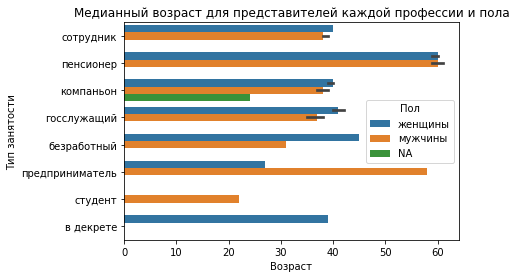

In [19]:
# Let's build a diagram showing the median age for each occupation and sex

ax = sns.barplot(x=df['dob_years'], 
            y=df['income_type'], 
            hue=df['gender'], 
            estimator=np.median)
plt.xlabel('Возраст') #задаем имя оси Х
plt.ylabel('Тип занятости') #задаем имя оси Y
ax.set_title("Медианный возраст для представителей каждой профессии и пола") #задаем название графика

legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['женщины', 'мужчины', 'NA'],
          title='Пол'); #задаем названия легенды

The diagram shows that for the categories **"сотрудник"**, **"пенсионер "**, **"компаньон "** and **"госслужащий "** the median age within the category for both men and women is approximately in the same range of values.  
However, for the categories **"безработный "**, **"предприниматель "** the values are different. Let's see if this can be caused by the insufficient amount of data

In [20]:
# Let's see the number of values of occupation categories for men
df[df['gender'] == 'M']['income_type'].value_counts()

сотрудник          4315
компаньон          1887
пенсионер           698
госслужащий         385
безработный           1
предприниматель       1
студент               1
Name: income_type, dtype: int64

In [21]:
# Let's see the number of values of occupation categories for women
df[df['gender'] == 'F']['income_type'].value_counts()

сотрудник          6804
компаньон          3197
пенсионер          3158
госслужащий        1074
в декрете             1
безработный           1
предприниматель       1
Name: income_type, dtype: int64

In [22]:
# let's see the total number of values of occupation categories
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

Можно увидеть, что действительно, клиентов с категориями занятости **"безработный"**, **"предприниматель"** находится всего лишь по 2 человека - 1 мужчина и 1-а женщина. Также, присутсвует всего лишь 1 мужчина-студент и 1-а женщина-в_декрете.  

В целом, это означает, что мы можем заполнить пропущенные значения лишь опираясь на медианные значения возраста для представителей каждого типа занятости.   
Однако для того, чтобы не так сильно икривлять распределение данных в сторону их медианного значения, сохраним небольшой разброс и все же заполним пропущенные значения, опираясь на медианный возраст, расчитанный для представителей каждого типа занятости и пола

Cоздадим датафрейм, в котором возраст не равен нулю и в котором остутсвуют пропуски в значениях дохода


In [23]:
df_dob_years_nonnull = df[(df['dob_years'] != 0)]
df_dob_years_nonnull = df_dob_years_nonnull.dropna(axis=0)
df_dob_years_nonnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19260 entries, 0 to 21524
Data columns (total 11 columns):
children            19260 non-null int64
dob_years           19260 non-null int64
education           19260 non-null object
education_id        19260 non-null int64
family_status       19260 non-null object
family_status_id    19260 non-null int64
gender              19260 non-null object
income_type         19260 non-null object
debt                19260 non-null int64
total_income        19260 non-null float64
purpose             19260 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


Найдем медианные значения возраста для представителя каждого пола и типа занятости и сохраним в таблицу `df_gender_income_type_median_age`


In [24]:
df_gender_income_type_median_age = df_dob_years_nonnull.groupby(['gender', 'income_type'])['dob_years'].quantile(.5)
df_gender_income_type_median_age

gender  income_type    
F       безработный        45.0
        в декрете          39.0
        госслужащий        42.0
        компаньон          40.0
        пенсионер          60.0
        предприниматель    27.0
        сотрудник          40.0
M       безработный        31.0
        госслужащий        37.0
        компаньон          38.0
        пенсионер          60.0
        сотрудник          38.0
        студент            22.0
XNA     компаньон          24.0
Name: dob_years, dtype: float64

Создадим признак age, в который сохраним медианные значения возраста из таблицы `df_gender_income_type_median_age`, где **dob_years=0**, и значения **dob_years**, там где они ненулевые

In [25]:
df['age'] = [df_gender_income_type_median_age[df.loc[i, 'gender']][df.loc[i, 'income_type']]  
             if df.loc[i, 'dob_years'] == 0
             else df.loc[i, 'dob_years'] 
             for i in range(len(df))]

In [26]:
#удалим столбец 'dob_years'
df = df.drop('dob_years', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
age                 21525 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.8+ MB


### Обработка пропусков в столбце `total_income`

Рассчитаем ежемесячный доход как средний доход для представителя каждого типа занятости и пола.

Наша гипотеза вновь состоит в том, что внутри каждого типа занятости, в засисимости от пола, доход будет различаться.
Посмотрим, действительно ли это так.

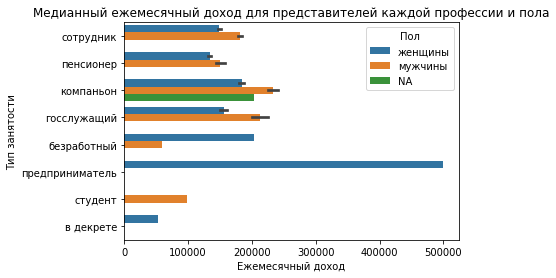

In [27]:
ax = sns.barplot(x=df['total_income'], y=df['income_type'], hue=df['gender'])

plt.xlabel('Ежемесячный доход')
plt.ylabel('Тип занятости')
ax.set_title("Медианный ежемесячный доход для представителей каждой профессии и пола")

legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['женщины', 'мужчины', 'NA'],
          title='Пол');

In [28]:
#вновь выведем на экран общее количество клиентов по каждой категории занятости
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [29]:
#посмотрим, представители каких типов занятости имеют пропуски в столбце 'total_income'
df[df['total_income'].isna()]['income_type'].unique()

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Из значений, которые небходимо заполнить, по категориям **"сотрудник"**, **"пенсионер"**, **"компаньон"** и **"госслужащий"** достаточно данных для представителей каждого пола. Проблема может лишь возникнуть с категорией **"предприниматель"**, так как к этой категории присутсвует лишь по одному представителю каждого пола, и как следствие, у нас может не найтись для него нужного значения.

Методом `fillna` + `groupby` + `transform` + `median` заполним пропуски в стобце `total_income` медианными значениями дохода для каждого пола и типа занятости.

In [39]:
df['total_income'] = df['total_income'].fillna(df.groupby(['gender', 'income_type'])['total_income'].transform('median'))

Проверим результат заполнения пропусков:

In [40]:
df[df['total_income'].isna()]

,children,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
5936,0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,58.0


Как и ожидалось, для клиента из категории "предприниматель-мужчина" нужного значения не нашлось.

Выведем на экран клиентов-предпринимателей.

In [41]:
df[df['income_type'] == 'предприниматель'].head()

,children,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
5936,0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,58.0
18697,0,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы,27.0


Возьмем значение из столбца `total_income` наиболее близкой по смыслу строки клиента из категории "предприниматель-женщина" и заполним им недостающее значение.

In [42]:
#заполним этим значением необходимую строку
df.loc[(df['income_type'] == 'предприниматель') & (df['gender'] == 'M'),'total_income'] = df.loc[18697, 'total_income']

Проверим результат заполнения. Выведем на экран оставшееся количество пропусков в столбе `total_income`

In [43]:
len(df[df['total_income'].isna()])

0

### Изменим значение пола 'XNA' на наиболее вероятное значение

Посмотрим на строку, в которой содержится значение `gender` == 'XNA'

In [44]:
df[df['gender'] == 'XNA']

,children,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age
10701,0,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,24.0


Посмотрим на распределение представителей разных полов в датафрейме

In [45]:
pd.crosstab(index=df['gender'], columns=df['gender'], normalize=True)

gender,F,M,XNA
gender,,,
F,0.66137,0.000000,0.000000
M,0.00000,0.338583,0.000000
XNA,0.00000,0.000000,0.000046


Видим, что у нас в таблице 66% женщин. Это означает, что если мы возмем случайного человека и предположим, что его пол - женский, мы будем правы в 66% случаев. Следовательно, с 66% вероятностью, можем присвоить данному объекту пол "женский"

In [46]:
#присвоим занчение 'F' нужной ячейке
df.loc[10701, 'gender'] = 'F'

#выведем эту ячейку, чтобы убедиться что мы измнили значение
df.loc[10701, 'gender']

'F'

In [47]:
#еще раз посмотрим на уникальные значние в столбце gender
df['gender'].unique(), df['gender'].isna().sum()

(array(['F', 'M'], dtype=object), 0)

Видим, что пропуски в столбце `gender` устранены

**Вывод по пунктам 2.1 - 2.4**

Итак, на данном этапе мы:
- Привели в порядок значения в стобце `children`
- Удалили столбец `days_employed`
- Исправили значения 0 в столбце `dob_years` и заменили его на столбец `age`. Столбец `age` заполнили путем расчета медианного возраста для представителя каждой профессии и соответсвующего пола.
- Заполнили пропуски в столбце `total_income`, путем нахождения медианного дохода для представителя каждой профессии и соответсвующего пола.
- Заполнили невяный пропуск в столбце `gender` наиболее вероятным значением

### Замена типа данных

Еще раз взглянем на типы данных


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
age                 21525 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.8+ MB


Метод **pd.to_numeric()** позволяет нам преобразовать тип `int64` в наиболее емкое в отношении занимаемой памяти тип (например, `int8`). Для того, чтобы оптимизировать память, занимаемую данными, выберем все столбцы, которые имеют тип `int` и применим к ним метод **pd.to_numeric()**

In [49]:
for col_name in df.select_dtypes(include=['int']).columns:
    df[col_name] = pd.to_numeric(df[col_name], downcast='integer')

In [50]:
#проверим изменения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int8
education           21525 non-null object
education_id        21525 non-null int8
family_status       21525 non-null object
family_status_id    21525 non-null int8
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int8
total_income        21525 non-null float64
purpose             21525 non-null object
age                 21525 non-null float64
dtypes: float64(2), int8(4), object(5)
memory usage: 1.2+ MB


Теперь проведем аналогичное преобразование для ячеек с типом **float**


In [51]:
for col_name in df.select_dtypes(include=['float']).columns:
    df[col_name] = pd.to_numeric(df[col_name], downcast='integer')

In [52]:
#проверим изменения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int8
education           21525 non-null object
education_id        21525 non-null int8
family_status       21525 non-null object
family_status_id    21525 non-null int8
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int8
total_income        21525 non-null float64
purpose             21525 non-null object
age                 21525 non-null int8
dtypes: float64(1), int8(5), object(5)
memory usage: 1.1+ MB


Видим, что в колонке `total_income` не удалось перобразовать тип методом **pd.to_numeric()**. Применим метод **astype('int')** вместе в функцией округления **round()**`

In [53]:
for col_name in df.select_dtypes(include=['float']).columns:
    df[col_name] = df[col_name].round(0).astype('int')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int8
education           21525 non-null object
education_id        21525 non-null int8
family_status       21525 non-null object
family_status_id    21525 non-null int8
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int8
total_income        21525 non-null int64
purpose             21525 non-null object
age                 21525 non-null int8
dtypes: int64(1), int8(5), object(5)
memory usage: 1.1+ MB


Видим, что все необходимые столбцы удалось преобразовать в целочисленный тип таким образом, чтобы данные занимали наименьшее количество места.

Чтобы еще больше оптимизировать количество памяти, которое занимает датафрейм, преобразуем признак "пол" в категориальный тип, методом `astype('category')`

In [55]:
#посмотрим, какой объем памяти занимает сейчас столбец gender в MB
print(f'{round(df.gender.memory_usage(deep=True) / 1024 ** 2, 3)} MB')

1.191 MB


In [56]:
#осуществим преобразование столбца gender к типу category
df['gender'] = df['gender'].astype('category')

In [57]:
#посмотрим, какой объем памяти занимает сейчас столбец gender после преобразования
print(f'{round(df.gender.memory_usage(deep=True) / 1024 ** 2, 3)} MB')

0.021 MB


In [58]:
#посмотрим еще раз на то, какие типы дынных у нас остались в датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int8
education           21525 non-null object
education_id        21525 non-null int8
family_status       21525 non-null object
family_status_id    21525 non-null int8
gender              21525 non-null category
income_type         21525 non-null object
debt                21525 non-null int8
total_income        21525 non-null int64
purpose             21525 non-null object
age                 21525 non-null int8
dtypes: category(1), int64(1), int8(5), object(4)
memory usage: 967.2+ KB


**Вывод**

Итак, на данном этапе мы:
- Преобразовали вещественный тип данных в столбцах `total_income` и `age`  в целочисленный.
- Оптимизировали объем памяти, занимаемой датафремом, путем приведения целочисленных столбцов `children`, `education_id`, `family_status_id`, `debt` к типу **int8**, а также путем приведения столбца `gender` к типу **category**

### Обработка дубликатов

Первым делом, займемся удалением неявных дубликатов. Для этого, приведем к одному регистру значения столбцов `education` и `family_status`

In [59]:
#приведем значения в столбцах 'education' и 'family_status' к нижнеу регистру
df['education'] = df['education'].str.lower()
df['family_status'] = df['family_status'].str.lower()

#выведем уникальные значения в столбцах 'education' и 'family_status' на экран
print(f'''
education - {df['education'].unique()} 
\n\n
family_status - {df['family_status'].unique()}
''')


education - ['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень'] 



family_status - ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'не женат / не замужем']



Теперь, посмотрим, сколько явных дубликатов присутсвует в таблице


In [60]:
df.duplicated().sum()

71

Причиной появления дубликатов в данных может служить неправильное соединение даных из разных источников.

Удалим явные дубликаты сбросим индексы


In [61]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

#снова проверим на наличие явных дубликатов после их удаления
df.duplicated().sum()

0

**Вывод**

На данном этапе мы:
- Избавились от неявных дубликатов в столбце `education`, путем приведения значений к одному регистру
- Удалили явные дубликаты из таблицы `df`

### Создание словаря

Для того, чтобы оптимизировать объем памяти, которое занимает таблица, а также для того, чтобы сделать датафрейм более лаконичным, вынесем словарь со значениями `education` - `education_id`, а также `family_status` - `family_status_id` в отдельные таблицы. В оснвоном датафрейме оставим лишь значения `education_id` и `family_status_id`

Создадим словарь со значениями `education` - `education_id`

In [62]:
education_dict = df.loc[:, ['education', 'education_id']]
education_dict.drop_duplicates(inplace=True) #удалим дубликаты
education_dict = education_dict.reset_index(drop=True) #сбросим индексы
education_dict #выведем словарь значений education - education_id на экран

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


Создадим словарь со значениями `family_status` - `family_status_id`

In [63]:
family_status_dict = df.loc[:, ['family_status', 'family_status_id']]
family_status_dict.drop_duplicates(inplace=True) #удалим дубликаты
family_status_dict = family_status_dict.reset_index(drop=True) #сбросим индексы
family_status_dict #выведем словарь значений 'family_status' - 'family_status_id' на экран

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


Удалим столбцы `family_status`, `education` из датафрейма `df`


In [64]:
df.drop(['family_status', 'education'], axis=1, inplace=True)

#выведем списком названия оставшихся колонок датафрейма
df.columns

Index(['children', 'education_id', 'family_status_id', 'gender', 'income_type',
       'debt', 'total_income', 'purpose', 'age'],
      dtype='object')

**Вывод**

На данном этапе, мы:
- Вынесли словари со значениями `education` - `education_id`, а также `family_status` - `family_status_id` в отдельные таблицы `education_dict` и `family_status_dict` соотвественно. 
- В основном датафрейме оставим лишь значения `education_id` и `family_status_id`, оптимизировав тем самым объем памяти, занимаемой таблицей

### Лемматизация

Для того, чтобы нам было удобно анализировать данные и соотносить объекты по целям взятия кредита, нам необходимо произвести категоризацию данных, представленных в столбце `purpose`.  
Для этого мы производем лемматизацию данных столбца

Посмотрим на уникальные значения, которые присутсвуют в столбце "purpose"


In [65]:
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Осуществим лемматизацию

In [66]:
#произведем лемматизацию строк -> соединим леммы в строку -> удалим лишние символы методом str.rstrip()
#сохраним значения в столбце "purpose_lem"

m = Mystem()
df['purpose_lem'] = ((df['purpose'].apply(m.lemmatize)).apply(' '.join)).str.rstrip(' \n') 

In [67]:
#посмотрим на уникальные значения, которые присутсвуют в столбце "purpose_lem"
df.purpose_lem.value_counts()

автомобиль                                    972
свадьба                                       791
на   проведение   свадьба                     768
сыграть   свадьба                             765
операция   с   недвижимость                   675
покупка   коммерческий   недвижимость         661
операция   с   жилье                          652
покупка   жилье   для   сдача                 651
операция   с   коммерческий   недвижимость    650
покупка   жилье                               646
жилье                                         646
покупка   жилье   для   семья                 638
строительство   собственный   недвижимость    635
недвижимость                                  633
операция   со   свой   недвижимость           627
строительство   жилой   недвижимость          624
покупка   недвижимость                        621
покупка   свой   жилье                        620
строительство   недвижимость                  619
ремонт   жилье                                607


Основные ключевые слова, которые встречаются:
- образование, 
- автомобиль, 
- свадьба, 
- недвижимость, жилье

**Вывод**

На данном этапе мы:
- Выявили неявные дубликаты в столбце `purpose`, за счет приведения слов в строке к лемме, и выделения ключевых слов, встречающихся в запросах

### Категоризация данных

На их основе выявленных ключевых слов создадим категории:
- образование
- покупка автомобиля
- свадьба
- операции с недвижимостью

Создадим словарь, в котором в качестве ключа будет лемма из столбца `purpose`, а в качестве значения - наименование категории.

In [68]:
purpose_dict = {"образование": "образование", 
                "автомобиль": "покупка автомобиля", 
                "свадьба": "свадьба", 
                "жилье": "недвижимость", 
                "недвижимость": "недвижимость"
               }

Cоздадим колонку `purpose_category` и заполним ее в соотвествии со словарем `purpose_dict`


In [69]:
df['purpose_category'] = [value 
                          for i in range(len(df))
                          for key, value in purpose_dict.items()
                          if key in df.loc[i, 'purpose_lem']]

In [70]:
#посмотрим, как выглядят столбцы 'purpose' и 'purpose_category'
df[['purpose', 'purpose_category']].head()

,purpose,purpose_category
0,покупка жилья,недвижимость
1,приобретение автомобиля,покупка автомобиля
2,покупка жилья,недвижимость
3,дополнительное образование,образование
4,сыграть свадьбу,свадьба


Cоздадим словарь для purpose_category_id и сохраним его в переменной `purpose_category_dict`

In [71]:
purpose_category_dict = {df.purpose_category.unique()[i]: i for i in range(len(df.purpose_category.unique()))}
purpose_category_dict

{'недвижимость': 0, 'покупка автомобиля': 1, 'образование': 2, 'свадьба': 3}

Cоздадим столбец датафрейме `df` и присвоим значения в соотвествии со словарем `purpose_category_dict`

In [72]:
df['purpose_category_id'] = df['purpose_category'].map(lambda x: purpose_category_dict[x])

#выведем на экран результат
df[['purpose', 'purpose_category', 'purpose_category_id']].head()

,purpose,purpose_category,purpose_category_id
0,покупка жилья,недвижимость,0
1,приобретение автомобиля,покупка автомобиля,1
2,покупка жилья,недвижимость,0
3,дополнительное образование,образование,2
4,сыграть свадьбу,свадьба,3


In [73]:
#проверим формат нового столбца
df.purpose_category_id.dtype

dtype('int64')

In [74]:
#преобразуем его к более емкому формату
df['purpose_category_id'] = pd.to_numeric(df['purpose_category_id'], downcast='integer')
df.purpose_category_id.dtype

dtype('int8')

Для удобства восприятия, преобразуем `purpose_category_dict` в датафрейм


In [75]:
purpose_category_dict = pd.DataFrame(data=purpose_category_dict, index = ['purpose_category_id']).T
purpose_category_dict

,purpose_category_id
недвижимость,0
покупка автомобиля,1
образование,2
свадьба,3


После того, как категоризация проведена, можно удалить лишние столбцы из датафрейма

In [76]:
df = df.drop(['purpose', 'purpose_lem', 'purpose_category'], axis=1)
df.columns

Index(['children', 'education_id', 'family_status_id', 'gender', 'income_type',
       'debt', 'total_income', 'age', 'purpose_category_id'],
      dtype='object')

Также, произведем категоризацию клиентов по уровню дохода. Для этого разделим значения дохода на 6 отрезков, равных (с погрешностью +/- 1 ) по количеству строк, представленных в каждой категории. Каждому из диапазонов будет присвоено название категории.  
Всего создадим 6 категорий: `'low_low'`, `'low_high'`, `'middle_low'`, `'middle_high'`, `'high_low'`, `'high_high'`.  

Для этого воспользуемся методом `qcut()`

Создадим столбец `income_category`, в который сохраним категорию дохода клиента. Категория будет присвоена в соответсвии с тем, в какой из диапазонов попадет значение признака `total_income` конкретного клиента.  

In [77]:
df['income_category'] = pd.qcut(df['total_income'], 
                                q=6, 
                                labels=['low_low', 'low_high', 'middle_low', 'middle_high', 'high_low', 'high_high'])
df.head()

,children,education_id,family_status_id,gender,income_type,debt,total_income,age,purpose_category_id,income_category
0,1,0,0,F,сотрудник,0,253876,42,0,high_high
1,1,1,0,F,сотрудник,0,112080,36,1,low_high
2,0,1,0,M,сотрудник,0,145886,33,0,middle_high
3,3,1,0,M,сотрудник,0,267629,32,2,high_high
4,0,1,1,F,пенсионер,0,158616,53,3,middle_high


Проверим, как распределены диапазоны дохода

In [78]:
df['income_category'].value_counts()

high_high      3576
middle_high    3576
low_high       3576
low_low        3576
high_low       3575
middle_low     3575
Name: income_category, dtype: int64

Видим, что нам удалось поделить клиентов на 6 интервалов-категорий, равных по количеству значений (с погрешностью +/- 1). С этим уже можно работать.

Для того, чтобы понимать какие диапазоны содержатся в каждой категории, создадим таблицу-словарик, в которой будут указаны минимальные и максимальные диапазоны дохода для каждой категории

In [79]:
income_category_dict = df.groupby('income_category')['total_income'].agg(['min', 'max'])
income_category_dict

,min,max
income_category,,
low_low,20667,92129
low_high,92164,119872
middle_low,119874,144121
middle_high,144133,173242
high_low,173247,228860
high_high,228893,2265604


**Вывод**

На данном этапе мы:
- Произвели лемматизацию значение столбца `purpose`
- Осуществили категоризацию столбца `purpose`. Всего было выделено 4 категории целей: **'недвижимость', 'покупка автомобиля', 'образование', 'свадьба'**.
- Каждой категории мы присвоили уникальный **id**  
- Призведено разбение клиентов на 6 категорий дохода:`'low_low'`, `'low_high'`, `'middle_low'`, `'middle_high'`, `'high_low'`, `'high_high'`.

## Шаг 3. Проверка гипотез. Ответ на вопросы заказчика

Следующим шагом, проверим гипотезы:
1. Есть зависимость между наличием детей и возвратом кредита в срок
2. Есть зависимость между семейным положением и возвратом кредита в срок
3. Есть зависимость между уровнем дохода и возвратом кредита в срок
4. Разные цели кредита влияют на его возврат в срок.

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Разделим клиентов на 6 групп, по количеству детей.  
Проананализируем, каков процент задолженностей, внутри каждой группы. Если, в какой-то из групп клиентов, отношение людей, имеющих задолженность к общему количеству людей внутри группы будет значительно выше, нежели в остальных - это может говорить о том, что количество детей коррелирует с риском невозврата кредита в срок

Построим сводную таблицу `child_debt_crosstab`


In [80]:
child_debt_crosstab = pd.crosstab(index=df['debt'],
                                  columns=df['children'], 
                                  normalize='columns', 
                                  margins=True, 
                                  )
child_debt_crosstab

children,0,1,2,3,4,5,All
debt,,,,,,,
0,0.924562,0.908342,0.905075,0.918182,0.902439,1.0,0.91885
1,0.075438,0.091658,0.094925,0.081818,0.097561,0.0,0.08115


Обратим внимание на вторую строку таблицы.  
В ней отображается отношение количества людей, которые не вернули займ в срок к общему количеству людей внутри каждой группы.  
Так, например, мы можем увидеть, что в группе людей, которые не имеют ни одного ребенка, доля должников составляет 0,075, в группе клиентов, имеющих 1-го ребенка доля должников составляет 0,09, а общая доля должников в датафрейме - 0,08

Отобразим значения на графике, где прямая линия отображает средний процент невозврата,расчитанный для всего датафрейма. 

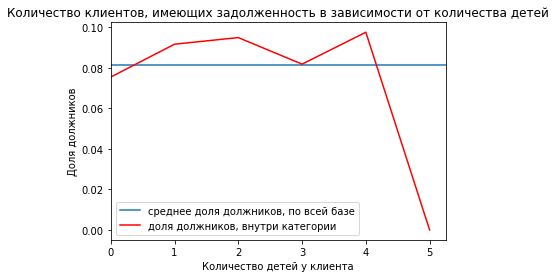

In [81]:
fig, ax = plt.subplots()

ax.axhline(y=child_debt_crosstab.iloc[1, 6], 
            label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax.plot(child_debt_crosstab.iloc[1, :6], 'r-', 
         label='доля должников, внутри категории') #доля должников в каждой группе клиентов

plt.legend() #включаем отбражение легенды
plt.xlim(left=0) #задаем начало графика
plt.xlabel('Количество детей у клиента') #задаем наименование оси Х
plt.ylabel('Доля должников') #задаем наименование оси Х
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от количества детей'); #задаем название графика

На графике наглядно видно, что наименьшая доля людей, не вернувших займ в срок имеет 0 детей, в то время как наиболшая доля людей, имеющих задолженность приходится на обладателей 2-х и 4-х детей.  
В категории 5 ("имеют 5 детей") наблюдается аномалия. Это может быть в следствии того, что датафрейм содержит очень мало данных о клиентах, имеющих 5 детей.   
Проверим, так ли это

In [82]:
df['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

Действительно, в данных содержится всего 9 таких строк. Следовательно, данную аномалию мы можем проигнорировать.  
Более того, об обладателях 3-х и 4-х детей также содержится мало данных.  
Однако в целом, можно заметить восходящую тенденцию невозврата кредита в срок, где доля должников внутри группы увеличивается в то время как увеличивается количество детей. Очень грубо говоря, можно сказать, что чем больше детей, тем больше вероятность того, что клиент не возвратит средства в срок.

**Вывод**


Зависимость между количеством детей и возвратом кредита в срок **присутвует**.
- Наибольшую долю должников составляют люди, имеющие 2 и 4 ребенка, в то время как наименьшаяя доля задолженностей приходится на группу клиентов, у которых нет ни одного ребенка  

В общем виде, вывод можно сформулировать следющим образом: чем больше детей у займополучателя, тем больше вероятность невозврата кредита в срок.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Аналогично тому, как мы анализировали влияния количества детей на факт наличия задолженности, проанализируем, есть ли зависимость между семейным статусом и фактом наличия задолженности.

Построим сводную таблицу `family_debt_crosstab`

In [83]:
family_debt_crosstab = pd.crosstab(index=df['debt'], 
                                   columns=df['family_status_id'], 
                                   margins=True, 
                                   normalize='columns'
                                  )

family_debt_crosstab

family_status_id,0,1,2,3,4,All
debt,,,,,,
0,0.924548,0.906529,0.934307,0.92887,0.902491,0.91885
1,0.075452,0.093471,0.065693,0.07113,0.097509,0.08115


Снова обратим внимание на нижнюю строку. Мы можем увидеть, что в группе 1 и 4 располагаются значения, которые имеют наибольшее отклонение от среднего, в то время как значение доли должников внутри группы 2 - наименьшее.

Для наглядности, построим график

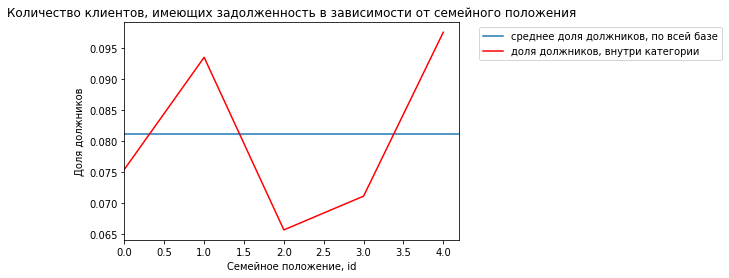

In [84]:
fig, ax = plt.subplots()

ax.axhline(y=family_debt_crosstab.iloc[1, 5], 
           label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax.plot(family_debt_crosstab.iloc[1, :5], 'r', 
        label='доля должников, внутри категории'); #доля должников в каждой группе клиентов

plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
plt.xlabel('Семейное положение, id')
plt.ylabel('Доля должников')
plt.xlim(left=0)
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от семейного положения');

In [85]:
#обратимся к словарю значений family_status_id и интерпретируем результат
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


Самый высокий процент невозврата у представителей группы 1 и 4 (гражданский брак и не женат / не замужем)  
Самый низкий процент невозврата у представителей группы 2 (вдовец / вдова)

На всякий случай проверим, достаточно ли данных внутри каждой категории семейного статуса

In [86]:
df['family_status_id'].value_counts()

0    12339
1     4151
4     2810
3     1195
2      959
Name: family_status_id, dtype: int64

Данных достаточно

**Вывод**

Есть зависимость между семейным положением и возвратом кредита в срок.  
- Наибольшая доля должников наблюдается среди клиентов с семейным статусом "гражданский брак" и "не женат / не замужем"
- Наименьшая доля должников наблюдается среди клиентов с семейным статусом "вдовец / вдова"

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [88]:
income_cat_debt_grouped = df.groupby('income_category')['debt'].mean()
income_cat_debt_grouped

income_category
low_low        0.079698
low_high       0.081655
middle_low     0.086154
middle_high    0.089485
high_low       0.080000
high_high      0.069911
Name: debt, dtype: float64

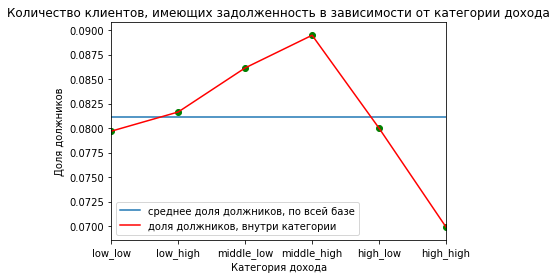

In [89]:
fig, ax = plt.subplots()

ax.axhline(y=family_debt_crosstab.iloc[1, 5], 
           label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax = income_cat_debt_grouped.plot(label='доля должников, внутри категории', style='r') #доля должников в каждой группе клиентов
ax.scatter(x=income_cat_debt_grouped.index, y=income_cat_debt_grouped, c='g') #для наглядности, отметим точки на графике

plt.legend()
plt.xlabel('Категория дохода')
plt.ylabel('Доля должников')
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от категории дохода');

Обратимся к словарю `income_category_dict` чтобы интерпретировать результат.

In [90]:
income_category_dict

,min,max
income_category,,
low_low,20667,92129
low_high,92164,119872
middle_low,119874,144121
middle_high,144133,173242
high_low,173247,228860
high_high,228893,2265604


Видим интересную зависимость  

Наибольшая доля должников наблюдается в категории людей с доходом **144133 - 173242**, в то время как наименьшая доля должников находится в группе людей с доходом **228893 - 2265604**

**Вывод:**  
Зависимость между уровнем дохода и возвратом кредита в срок практически **присутствует**.  

Больше всего людей, задержавших выплату по займу находится в группе клиентов с доходом **228893 - 2265604**. В свою очередь, наименьшее количество должников было обнаружено в группе клиентов с наивысшим показателем ежемесячного дохода.  

При этом, наблюдается следующая тенденция. По мере увеличения уровня ежемесячного дохода от диапазона **low_low [20667 - 92129)** к диапазону **middle_high [144133 - 173242)** доля должников увеличивается, в то время как начиная с диапазона **high_low [173247 - 228860)** и выше доля должников резко начинает снижаться и располагается ниже среднего уровня доли должников, расчитанного для всей базы.

### Как разные цели кредита влияют на его возврат в срок?

Аналогично тому, как мы анализировали влияния количества детей на факт наличия задолженности, проанализируем, есть ли зависимость между целями кредита и фактом наличия задолженности.

Построим сводную таблицу:

In [91]:
purpose_debt_crosstab = pd.crosstab(index=df['debt'], 
                                    columns=df['purpose_category_id'], 
                                    normalize='columns', 
                                    margins=True)

purpose_debt_crosstab

purpose_category_id,0,1,2,3,All
debt,,,,,
0,0.927666,0.90641,0.9078,0.919966,0.91885
1,0.072334,0.09359,0.0922,0.080034,0.08115


Для наглядности, отобразим процент должников внутри каждой группы на графике.

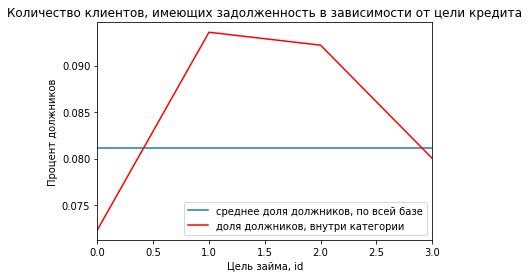

In [92]:
fig, ax = plt.subplots()

ax.axhline(y=purpose_debt_crosstab.iloc[1, 4], 
           label='среднее доля должников, по всей базе') #среднее количество должников для все базы клиентов
ax.plot(purpose_debt_crosstab.iloc[1, :4], 'r', 
    label='доля должников, внутри категории'); #доля должников в каждой группе клиентов

plt.legend()
plt.xlim(left=0, right=3)
plt.xlabel('Цель займа, id')
plt.ylabel('Процент должников')
ax.set_title('Количество клиентов, имеющих задолженность в зависимости от цели кредита');

На графике наглядно видно, что наибольшая доля людей с задолженность находится в группах 1 и 2  
В то же время наименьшая доля людей не вернувших долг в срок находится в группе 0

Обратимся к словарю значений `family_status_id` и интерпретируем результат

In [93]:
purpose_category_dict

,purpose_category_id
недвижимость,0
покупка автомобиля,1
образование,2
свадьба,3


Наибольшая доля людей не вернувших займ в срок находится среди людей, которые брали кредит на цели "покупка автомобиля" и "образование"
Наименьшая доля людей не вернувших займ в срок находится среди людей, которые брали кредит на цели "недвижимость"

На всякий случай проверим, достаточно ли данных внутри каждой категории целей кредита

In [94]:
df['purpose_category_id'].value_counts()

0    10811
1     4306
2     4013
3     2324
Name: purpose_category_id, dtype: int64

Данных достаточно.

**Вывод**

Цели кредита влияют на срок его возврата.  
При этом, наибольшая доля людей не вернувших займ в срок находится среди людей, которые брали кредит на цели "покупка автомобиля" и "образование", а наименьшая доля - среди людей, которые брали кредит на цели "недвижимость"

## Шаг 4. Общий вывод

В ходы работы над предобработкой данных были проделаны следующие шаги:
- Были выялвены и устранены ошибки в данных
- Были выявленны и удалены явные и неявные дубликаты
- Был оптимизирован объем, занимаемый датафремом, за счет оптимизации формата, в котором хранятся переменные таблицы, а также за счет вынесения одинаковых посмыслу признаков в отдельные датафреймы-словари.
- Были заполнены пропуски в данных.
- Была произведена категоризация признака `purpose`, в результате чего были выделены 4 категории цели взятия кредита, а именно: 
 - образование
 - покупка автомобиля
 - свадьба
 - операции с недвижимостью
- Была произведена категоризация клиентов по уровню ежемесячного дохода, путем приминения функции дискретизации на основе квантилей `qcut()` на 6 категорий: `'low_low'`, `'low_high'`, `'middle_low'`, `'middle_high'`, `'high_low'`, `'high_high'`. 

В ходе аналитической работы, были проверены 4 гипотезы, а именно:
1. Есть зависимость между наличием детей и возвратом кредита в срок
2. Есть зависимость между семейным положением и возвратом кредита в срок
3. Есть зависимость между уровнем дохода и возвратом кредита в срок
4. Разные цели кредита влияют на его возврат в срок.  

В результате, все 4 гипотезы были подтверждены:
1. Есть зависимость между наличием детей и возвратом кредита в срок. Чем больше детей, тем выше вероятность того, что клиент просрочит кредит
2. Есть зависимость между семейным положением и возвратом кредита в срок. Человек с большей вероятностью задержит возврат кредита, если он относится к категории клиентов с семейным статусом "гражданский брак" и "не женат / не замужем". Меньшая вероятность задержки возврата кредита наблюдается у клиентов с семейным статусом "вдовец / вдова"
3. Есть зависимость между уровнем дохода и возвратом кредита в срок. Наибольшее доля должнико наблюдается в категории клиентов middle_high с доходом [228893 - 2265604). Наименьшая доля клиентов, задержавших выплаты находится в категории high_high [228893 - 2265604). При этом, По мере увеличения уровня ежемесячного дохода от диапазона low_low [20667 - 92129) к диапазону middle_high [144133 - 173242) доля должников увеличивается, в то время как начиная с диапазона high_low [173247 - 228860) и выше доля должников резко начинает снижаться и располагается ниже среднего показателя доли должников, расчитанного для всей базы.
4. Разные цели кредита влияют на его возврат в срок. Наибольшая доля клиентов, которые просрочили кредит находится среди клиентов, которые взяли кредит на "покупку автомобиля" и на оплату "образования", наименьшая - среди людей, которые брали кредит для проведения операций с "недвижимостью"  


